# Whole Brain Searchlight

This is the (heavily) adapted searchlight classification script being deployed for the Round Robin Person Decoding analysis project. Originally by BrainIAK and adapted and deployed by *Aussie Frost* of CSNL. Updated May 2023.

## Loading Data (For Reference)

In [1]:
#supress warnings and make imports
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
from brainiak.utils import fmrisim as sim

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

/packages/miniconda/20190102/envs/brainiak-20221110/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


Autosaving every 5 seconds


In [2]:
# Load and perpare data for one subject (unneeded)
def load_fs_data(data_path, sub_id, mask=''):
    # find file path
    sub = 'sub-' + (sub_id)
    input_dir = os.path.join(data_path, sub)
    data_file = os.path.join(input_dir, '_ses-wave1_task-RR_acq-1_bold_trimmed.nii.gz')
    label_file =  os.path.join(input_dir, 'label.npz') 
    if mask == '':
        mask_file = os.path.join(data_path, 'wb_mask.nii.gz')
    else:
        mask_file = os.path.join(data_path, '{}_mask.nii.gz'.format(mask))

    # load bold data and some header information so that we can save searchlight results later
    data_file = nib.load(data_file)
    bold_data = data_file.get_fdata()
    affine_mat = data_file.affine
    dimsize = data_file.header.get_zooms() 
    
    # load label
    label = np.load(label_file)
    label = label['label']

    # load mask
    brain_mask = nib.load(mask_file)
    brain_mask = brain_mask.get_fdata()

    return bold_data, label, brain_mask, affine_mat, dimsize

In [3]:
#data = pd.read_csv("/projects/csnl/shared/round_robin_qc/analysis/braniak_tutorials/G01S01_onsets_ITI.csv")
data = pd.read_csv("/projects/csnl/shared/round_robin_qc/analysis/no_st_qc/sl_train_G01S01.csv")
print(data)
data = data.values
data

    Volume   Target   Run
0        0        1     1
1        1        2     1
2        2        3     1
3        3        4     1
4        4        5     1
5        5        1     2
6        6        2     2
7        7        3     2
8        8        4     2
9        9        5     2
10      10        1     3
11      11        2     3
12      12        3     3
13      13        4     3
14      14        5     3
15      15        1     4
16      16        2     4
17      17        3     4
18      18        4     4
19      19        5     4
20      20        1     5
21      21        2     5
22      22        3     5
23      23        4     5
24      24        5     5


array([[ 0,  1,  1],
       [ 1,  2,  1],
       [ 2,  3,  1],
       [ 3,  4,  1],
       [ 4,  5,  1],
       [ 5,  1,  2],
       [ 6,  2,  2],
       [ 7,  3,  2],
       [ 8,  4,  2],
       [ 9,  5,  2],
       [10,  1,  3],
       [11,  2,  3],
       [12,  3,  3],
       [13,  4,  3],
       [14,  5,  3],
       [15,  1,  4],
       [16,  2,  4],
       [17,  3,  4],
       [18,  4,  4],
       [19,  5,  4],
       [20,  1,  5],
       [21,  2,  5],
       [22,  3,  5],
       [23,  4,  5],
       [24,  5,  5]])

In [4]:
# show data
data

array([[ 0,  1,  1],
       [ 1,  2,  1],
       [ 2,  3,  1],
       [ 3,  4,  1],
       [ 4,  5,  1],
       [ 5,  1,  2],
       [ 6,  2,  2],
       [ 7,  3,  2],
       [ 8,  4,  2],
       [ 9,  5,  2],
       [10,  1,  3],
       [11,  2,  3],
       [12,  3,  3],
       [13,  4,  3],
       [14,  5,  3],
       [15,  1,  4],
       [16,  2,  4],
       [17,  3,  4],
       [18,  4,  4],
       [19,  5,  4],
       [20,  1,  5],
       [21,  2,  5],
       [22,  3,  5],
       [23,  4,  5],
       [24,  5,  5]])

In [5]:
run_id = 1

#time_points_mask = data[:, 2] #== run_id

labels = data[:, 1]

volumes = data[:, 0]

print('targets:\n\n %s \n\n' % labels)
print('volumes:\n\n%s' % volumes)

targets:

 [1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5] 


volumes:

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


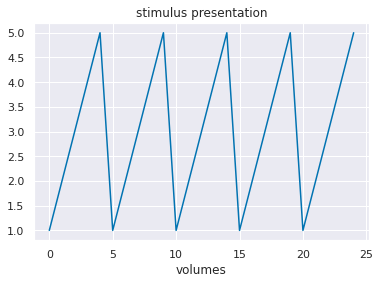

In [6]:
# Make an empty plot
plt.figure()

# Plot the data
plt.plot(volumes, labels)

# you can add plot title like this
plt.title('stimulus presentation')

# you can set xlabel like this
plt.xlabel('volumes');

In [7]:
label_dict = {1 : "target1", 2 : "target2", 3 : "target3", 4 : "target4", 5 : "target5"}

([<matplotlib.axis.XTick at 0x2aaad92b9208>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

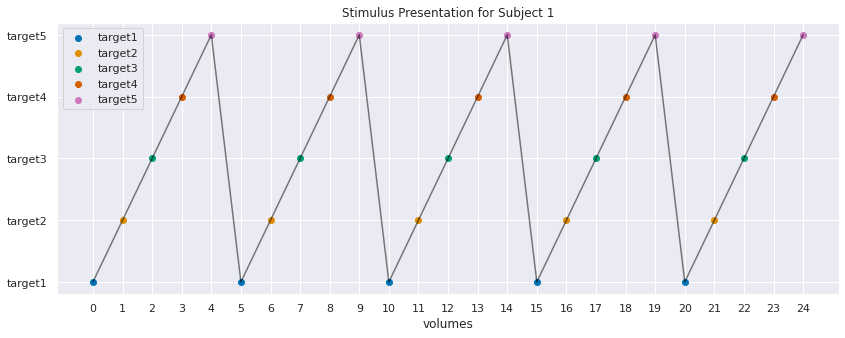

In [8]:
n_conditions = len(label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# create a plotting panel 
f, ax = plt.subplots(1,1, figsize = (14, 5))

# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(volumes[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(label_dict.values())

# connect the dots 
ax.plot(volumes, labels, color = 'black', alpha = .5)

# mark the plot
ax.set_title('Stimulus Presentation for Subject %s' % (run_id))
ax.set_yticks(list(label_dict.keys()))
ax.set_yticklabels(label_dict.values())
ax.set_xlabel('volumes');
plt.xticks(volumes)

In [9]:
### load fmri data

In [10]:
# time shift the data labels to account for HRF lag
n_conditions = len(label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (TRs_run - 1) * 2 + 1, 2)
time_vals = data[0:185, 0]
labels = data[0:185, 1]

f, ax = plt.subplots(1,1, figsize = (14, 5))
    
# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_vals[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(label_dict.values())
    
# plot the stimuli as a line 
# ax.plot(time_vals, labels, color = 'black', alpha = .5)
ax.plot(tr_time, stim_label_TR[0:TRs_run, 0], c='orange', alpha = .5)

ax.set_yticks(list(label_dict.keys()))
ax.set_yticklabels(label_dict.values())

ax.set_title('Stimulus Presentation for Run 1')
ax.set_xlabel('Time in secs')


NameError: name 'TRs_run' is not defined

## Searchlight (Single Subject)

In [11]:
# Import libraries
import os, sys
import pandas as pd
import nibabel as nib
import numpy as np 
import time
from nilearn import plotting
from brainiak.searchlight.searchlight import Searchlight
from brainiak.fcma.preprocessing import prepare_searchlight_mvpa_data
from brainiak import io
from pathlib import Path
from shutil import copyfile

# Import machine learning libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm
from scipy.stats import zscore
from nilearn.masking import compute_epi_mask
from mpi4py import MPI

# Import analytics libraries
import matplotlib.pyplot as plt
import seaborn as sns 

# Surpress warnings
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# %matplotlib inline 
%matplotlib notebook
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [12]:
# Define helper function
def load_epi_data(subject_name):
    # Load MRI file (in Nifti format) of one localizer run
    epi_in = os.path.join(data_dir, "%s_merged.nii.gz" % (subject_name)) # iiiiii
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

In [13]:
# Define general subject info
subject_name = 'G01S01'
n_runs = 5

# Define data paths
data_dir = "/projects/csnl/shared/round_robin_qc/analysis/endorsement/merged_sl/no/"
results_dir = "/projects/csnl/shared/round_robin_qc/analysis/braniak_tutorials/output/"
mask_dir = "/projects/csnl/shared/round_robin_qc/analysis/no_st_qc/sub-%s/model/runA.feat/" % (subject_name)

# Load niftis
epi_in = os.path.join(data_dir, "%s_merged.nii.gz" % (subject_name))
bold_data = nib.load(epi_in)
mask_in = os.path.join(mask_dir, "mask.nii.gz")
mask = nib.load(mask_in)

# Load onsets
onsets = pd.read_csv("/projects/csnl/shared/round_robin_qc/analysis/no_st_qc/sl_train_G01S01.csv")
onsets = onsets.values

# Load run_ids
run_ids = onsets[:,2] - 1
print(run_ids)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]


In [14]:
# Pull out the MPI information
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

In [15]:
# Output data path TODO ensure doing per subject output
output_path = os.path.join(results_dir,'searchlight_results')
if rank == 0:
    if not os.path.exists(output_path):
        os.makedirs(output_path)

In [16]:
# Define our mask
mask = mask.get_fdata()
coords = np.where(mask)

In [17]:
# Load the data in rank 0
if rank == 0:
    # Make a function to load the data for one subject's merge file
    def load_data(mask_in, subject_name):
        epi_data = load_epi_data(subject_name)
        print(("Finished load sub %s" % (subject_name)))
        bold_data = epi_data.get_data()
        print(("Finished getdata sub %s" % (subject_name)))
        print(bold_data.shape)
        affine_mat = epi_data.affine
        print(("Finished affine sub %s" % (subject_name)))
        dimsize = epi_data.header.get_zooms()
        print(("Finished dim sub %s" % (subject_name)))
        return bold_data, affine_mat, dimsize
    
    # Use load_data to write to data   
    data, affine_mat, dimsize = load_data(epi_in, subject_name)
    print(data.shape)
    print(mask.shape)
    # extract bold data for non-zero labels
    #data = data[:, :, :, label_index]
else:
    data = None

Loading data from /projects/csnl/shared/round_robin_qc/analysis/endorsement/merged_sl/no/G01S01_merged.nii.gz
Finished load sub G01S01
Finished getdata sub G01S01
(104, 104, 72, 25)
Finished affine sub G01S01
Finished dim sub G01S01
(104, 104, 72, 25)
(104, 104, 72)


To run the [searchlight](http://brainiak.org/docs/brainiak.searchlight.html) function in BrainIAK you need the following parameters:  

1. **data** = The brain data as a 4D volume.  
2. **mask** = A binary mask specifying the "center" voxels in the brain around which you want to perform searchlight analyses. A searchlight will be drawn around every voxel with the value of 1. Hence, if you chose to use the wholebrain mask as the mask for the searchlight procedure, the searchlight may include voxels outside of your mask when the "center" voxel is at the border of the mask. It is up to you to decide whether then to include these results.  
3. **bcvar** = An additional variable which can be a list, numpy array, dictionary, etc. you want to use in your searchlight kernel. For instance you might want the condition labels so that you can determine to which condition each 3D volume corresponds. If you don't need to broadcast anything, e.g, when doing RSA, set this to 'None'.  
4. **sl_rad** = The size of the searchlight's radius, excluding the center voxel. This means the total volume size of the searchlight, if using a cube, is defined as: ((2 * sl_rad) + 1) ^ 3.  
5. **max_blk_edge** = When the searchlight function carves the data up into chunks, it doesn't distribute only a single searchlight's worth of data. Instead, it creates a block of data, with the edge length specified by this variable, which determines the number of searchlights to run within a job.  
6. **pool_size** = Maximum number of cores running on a block (typically 1).  

In [18]:
# Load targets (each subject target)
labels = onsets[:,1] - 1

# Split data according to run ids
ps = PredefinedSplit(run_ids)

# Save them as the broadcast variables
bcvar = [labels, ps]

In [19]:
bcvar

[array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
        2, 3, 4]),
 PredefinedSplit(test_fold=array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4]))]

In [20]:
# Preset the variables to be used in the searchlight
data = data
mask = mask
bcvar = bcvar
sl_rad = 1 # (in mm)
max_blk_edge = 5
pool_size = 1

# Start the clock to time searchlight
begin_time = time.time()

# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)
print("Setup searchlight inputs")
print("Input data shape: " + str(data.shape))
print("Input mask shape: " + str(mask.shape) + "\n")

# Distribute the information to the searchlights (preparing it to run)
sl.distribute([data], mask)

# Broadcast variables
sl.broadcast(bcvar)

Setup searchlight inputs
Input data shape: (104, 104, 72, 25)
Input mask shape: (104, 104, 72)



In [ ]:
# dummy test classifier, not for use!!

# Set up the kernel function, in this case an SVM (use linear SVM , LORO)
def calc_svm(data, sl_mask, myrad, bcvar):
    if np.sum(sl_mask) < 14:
        return -1
    scores = []
    #cnf_matrix = []
    specificity = []
    sensitivity = []
    labels, ps = bcvar[0], bcvar[1]

    # Reshape the data
    sl_num_vx = sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2]
    num_epoch = data[0].shape[3]
    data_sl = data[0].reshape(sl_num_vx, num_epoch).T
    
    # Classifier: loop over all runs to leave each run out once
    model = LinearSVC()
    for train_index, test_index in ps.split():
        X_train, X_test = data_sl[train_index], data_sl[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # Fit a svm
        model.fit(X_train, y_train)
        # Calculate the accuracy for the hold out run
        score = model.score(X_test, y_test)
        scores.append(score)
        #print('score')
        #print(score)
        
        # Calculate the specificity
        y_true = y_test
        y_pred = model.predict(X_test)
        #print('y_true')
        #print(y_true)
        #print('y_pred')
        #print(y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred, labels=y_true) # this might be wrong # tn, fp, fn, tp
        #cm = skm.multilabel_confusion_matrix(y_true, y_pred, labels=y_true)
        #print('confusion matrix output')
        #print(cm)
        #cnf_matrix.append(cm)
        #print(specificity)
        print(cnf_matrix)
        
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate (we are getting macro-recall)
        TPR = TP/(TP+FN)
        sensitivity.append(TPR)
        #print(TPR)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        specificity.append(TNR)
        #print(TNR)
        
        
        # Calculate the sensitivity
        #cm_report = skm.classification_report(y_true ,y_pred, output_dict=True)
        #sensitivity = cm_report['weighted avg']['recall'] #tn / (tn+fp)
        #sensitivities.append(sensitivity)
        #print('sensitivity')
        #print(sensitivity)
        #print(sensitivities)
    
    
    
    print('arrays: scores')
    print(scores)
    print('arrays: sensitivity')
    print(sensitivity)
    print('arrays: specificity')
    print(specificity)
    print('final scores: scores, sensitivity, specificity')
    print(np.mean(scores), np.mean(sensitivity), np.mean(specificity))
        
    return np.mean(scores)

In [21]:
# Set up the kernel function, in this case an SVM (use linear SVM , LORO)
def calc_svm(data, sl_mask, myrad, bcvar):
    if np.sum(sl_mask) < 14:
        return -1
    scores = []
    #cnf_matrix = []
    specificity = []
    sensitivity = []
    labels, ps = bcvar[0], bcvar[1]

    # Reshape the data
    sl_num_vx = sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2]
    num_epoch = data[0].shape[3]
    data_sl = data[0].reshape(sl_num_vx, num_epoch).T
    
    # Classifier: loop over all runs to leave each run out once
    model = LinearSVC()
    for train_index, test_index in ps.split():
        X_train, X_test = data_sl[train_index], data_sl[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # Fit a svm
        model.fit(X_train, y_train)
        # Calculate the accuracy for the hold out run
        score = model.score(X_test, y_test)
        scores.append(score)
        
        # Generate a confusion matrix to get sensitivity, specificity
        y_true = y_test
        y_pred = model.predict(X_test)
        cnf_matrix = confusion_matrix(y_true, y_pred, labels=y_true) # this might be wrong # tp, fn, fp, tn
        #print(cnf_matrix)
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Calculate the Sensitivity, hit rate, recall, or true positive rate (we are getting macro-recall)
        TPR = TP/(TP+FN)
        #print(TPR)
        sensitivity.append(TPR)
        # Calculate the Specificity or true negative rate
        TNR = TN/(TN+FP)
        #print(TNR)
        specificity.append(TNR)

    #print('arrays: accuracy')
    #print(scores)
    #print('arrays: sensitivity')
    #print(sensitivity)
    #print('arrays: specificity')
    #print(specificity)
    print('final scores: accuracy, sensitivity, specificity')
    print(np.mean(scores), np.mean(sensitivity), np.mean(specificity))
        
    return np.mean(scores), np.mean(sensitivity), np.mean(specificity)

In [22]:
# inspecting the SL function (arbitrary)
import inspect
sc = inspect.getsource(sl.run_searchlight)
#print(sc)

sp = sl.run_searchlight.__globals__['__file__']
#print(sp)

#/packages/miniconda/20190102/envs/brainiak-20221110/lib/python3.6/site-packages/brainiak/searchlight/searchlight.py

In [23]:
output_path

'/projects/csnl/shared/round_robin_qc/analysis/braniak_tutorials/output/searchlight_results'

In [ ]:
# Run the searchlight analysis
print("Begin SearchLight in rank %s\n" % rank)
sl_result = sl.run_searchlight(calc_svm, pool_size=pool_size)
print("End SearchLight in rank %s\n" % rank)

# Only save the data if this is the first core
if rank == 0:
    # Convert NaN to 0 in the output
    sl_result = np.nan_to_num(sl_result[mask==1])
    # Reshape
    result_vol = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2]))  
    result_vol[coords[0], coords[1], coords[2]] = sl_result   
    # Convert the output into what can be used
    result_vol = result_vol.astype('double')   
    
    # Save the average result
    output_name = os.path.join(output_path, '%s_MPFC_SL.nii.gz' % (subject_name))
    sl_nii = nib.Nifti1Image(result_vol, affine_mat)
    hdr = sl_nii.header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
    nib.save(sl_nii, output_name)  # Save    
    
    print('Finished searchlight')
    end_time = time.time()
    print('Total searchlight duration (including start up time): %.2f' % (end_time - begin_time))

In [ ]:
# then adapt to run across all subjects! no

In [ ]:
# output an accuracy map for each subject
# and then accuracy map - chance (-.2 or 20%)
# and optionally, sensitivity and specificity as additional nifty files